In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
# Load data
water_quality = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-05-20/water_quality.csv')
weather = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-05-20/weather.csv')

# Convert date column
water_quality["date"] = pd.to_datetime(water_quality["date"])
weather["date"] = pd.to_datetime(weather["date"])


In [4]:
# Keep rows with non-null key variables
water_df_clean = water_quality.dropna(subset=["date", "enterococci_cfu_100ml"])


In [5]:
merged_rows = []

for date in water_df_clean["date"].unique():
    wq_day = water_df_clean[water_df_clean["date"] == date]
    wx_day = weather[weather["date"] == date]

    if wx_day.empty or wq_day.empty:
        continue

    tree = BallTree(np.deg2rad(wx_day[["latitude", "longitude"]].values), metric="haversine")
    distances, indices = tree.query(np.deg2rad(wq_day[["latitude", "longitude"]].values), k=1)

    needed_weather_cols = ["precipitation_mm", "max_temp_C", "min_temp_C"]
    nearest_weather = wx_day.iloc[indices.flatten()][needed_weather_cols].reset_index(drop=True)

    combined = pd.concat([wq_day.reset_index(drop=True), nearest_weather], axis=1)
    merged_rows.append(combined)

merged_df = pd.concat(merged_rows, ignore_index=True)
merged_df.to_csv("merged_weather_water_data.csv", index=False)


In [6]:
# Prepare analysis data
analysis_df = merged_df[[
    "date", "enterococci_cfu_100ml", "precipitation_mm", 
    "max_temp_C", "min_temp_C", "latitude", "longitude"
]].dropna()
analysis_df["date"] = pd.to_datetime(analysis_df["date"])

# Basic data summary
print("样本数量:", len(analysis_df))
print("检测日期范围:", analysis_df['date'].min(), "至", analysis_df['date'].max())
print("肠球菌浓度最大值:", analysis_df["enterococci_cfu_100ml"].max())


样本数量: 123223
检测日期范围: 1991-09-19 00:00:00 至 2025-04-28 00:00:00
肠球菌浓度最大值: 1100000.0


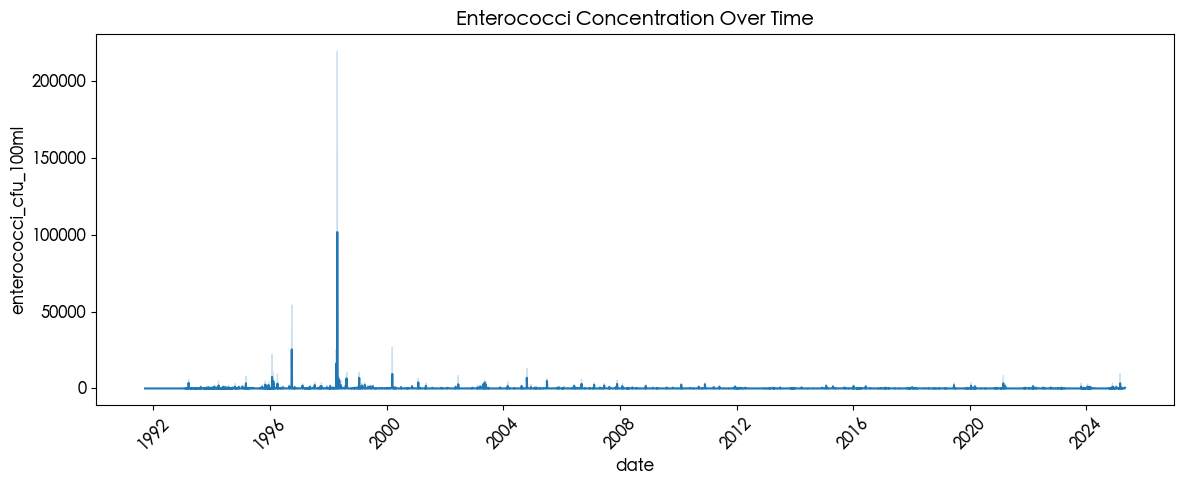

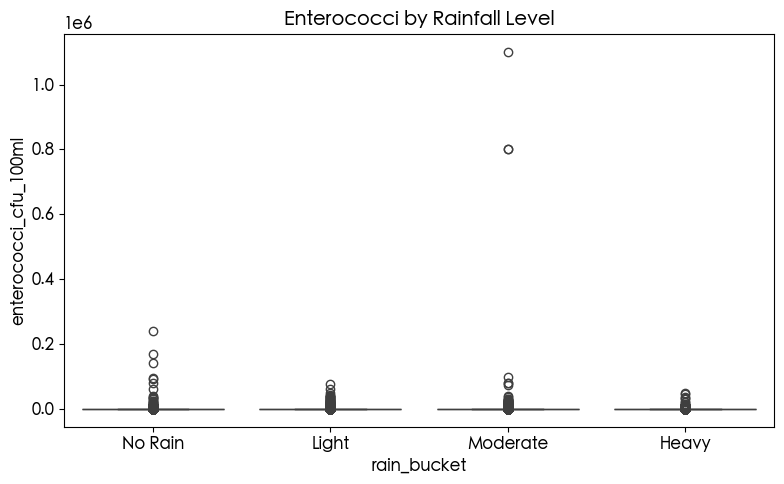

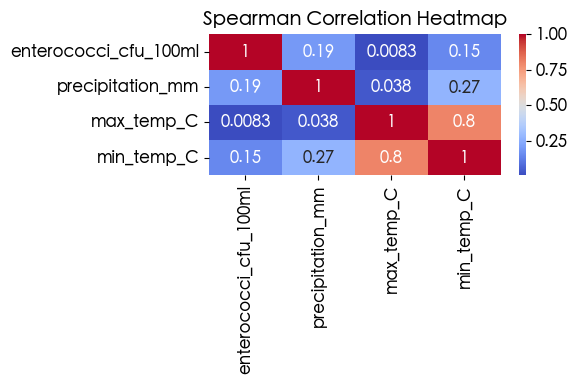

In [7]:
# Time series plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=analysis_df.sort_values("date"), x="date", y="enterococci_cfu_100ml")
plt.title("Enterococci Concentration Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot grouped by rainfall level
rain_bins = [-0.01, 0.1, 5, 20, 100]
rain_labels = ["No Rain", "Light", "Moderate", "Heavy"]
analysis_df["rain_bucket"] = pd.cut(analysis_df["precipitation_mm"], bins=rain_bins, labels=rain_labels)

plt.figure(figsize=(8, 5))
sns.boxplot(data=analysis_df, x="rain_bucket", y="enterococci_cfu_100ml")
plt.title("Enterococci by Rainfall Level")
plt.tight_layout()
plt.show()

# Spearman correlation heatmap
corr_matrix = analysis_df[[
    "enterococci_cfu_100ml", "precipitation_mm", "max_temp_C", "min_temp_C"
]].corr(method='spearman')

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Spearman Correlation Heatmap")
plt.tight_layout()
plt.show()


In [8]:
# Calculate Spearman & Pearson correlation
spearman_corr, spearman_p = spearmanr(analysis_df["precipitation_mm"], analysis_df["enterococci_cfu_100ml"])
pearson_corr, pearson_p = pearsonr(analysis_df["precipitation_mm"], analysis_df["enterococci_cfu_100ml"])
print(f"Spearman: {spearman_corr:.2f} (p={spearman_p:.4f})")
print(f"Pearson : {pearson_corr:.2f} (p={pearson_p:.4f})")


Spearman: 0.19 (p=0.0000)
Pearson : 0.03 (p=0.0000)


Spearman = 0.19
	•	表示 降雨量与肠球菌浓度之间存在轻微的“单调正相关”关系。
	•	趋势是：雨越大，肠球菌可能越高，但相关性不强。
	•	虽然数值不大，但 p 值非常小（显著），说明这个关系 在统计上是可信的。
	
Pearson = 0.03
	•	几乎没有线性关系（很接近 0）。
	•	说明 降雨量和肠球菌浓度之间的关系可能是非线性的，比如：
	•	无雨时浓度低；
	•	小雨影响不大；
	•	大雨后污染突增。

这也解释了为什么 Spearman 有效，Pearson 不显著。

### 雨量与水质（肠球菌）之间存在弱但显著的正向关系，而且这种关系更像是非线性、单调趋势，而不是线性关系。

In [9]:
# Prediction model
X = analysis_df[["precipitation_mm", "max_temp_C", "min_temp_C"]]
y = analysis_df["enterococci_cfu_100ml"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Random Forest 回归：MSE={mse:.2f}, R²={r2:.2f}")


Random Forest 回归：MSE=25340506.09, R²=0.16
